<div class='alert' style='background-color: #273333; color: #E5E7E8; padding:26px 26px; border-radius:15px; font-size:40px;'><B>Show Up </B> for Health - Deep Learning + No Shows</div><span style='color: #273333; padding:26px 26px; font-size:11px;'> Powered by <B>AutoNote </B>and<b> 🍏 ShowUp </b>helper class</B></span><div style='margin:4px 26px; color:#273333; font-size:17px;'>
<ol>
<li><B>Problem statement</B>: A clear description of the problem the project aims to solve.</li><BR>
<li><B>Data source</B>: Information on where the data used in the project is obtained from.</li><BR>
<li><B>Libraries used</B>: A list of the Python libraries used in the project and a brief explanation of their role. Include library version.</li><BR>
<li><B>Exploratory Data Analysis (EDA)</B>: A summary of the initial findings from exploring the data.</li><BR>
<li><B>Preprocessing</B>: Steps taken to clean and prepare the data for model building.</li><BR>
<li><B>Model building</B>: An overview of the model used and the reasoning behind its selection.</li><BR>
 Precision = $\frac{\text{true positives}}{\text{true positives + false positives}}$, Recall = $\frac{\text{true positives}}{\text{true positives + false negatives}}$, F1 = $2 \times \frac{\text{precision} \times \text{recall}}{\text{precision + recall}}$</li><BR><BR>
<li><B>Model evaluation</B>: Evaluation metrics used to assess the performance of the model and results of the evaluation.</li><BR>
<li><B>Conclusion</B>: A summary of the findings and recommendations for further work.</li>
</ol>
</div>

#  🍏 Loading Helper Class

wandb_api_key: 651204c459ad2877b0d32ae2f37ce28d159a9cbe

In [1]:
import wandb
wandb.login()

wandb: Currently logged in as: drjanduplessis (bromptonhealthpcn). Use `wandb login --relogin` to force relogin


True

In [2]:
# Importing default Libraries
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set the maximum number of rows and columns to be displayed
warnings.filterwarnings('ignore')

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

# 📙 Loading Libraries

In [3]:
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from showupforhealth.params import *
from showupforhealth.utils import *


# 💾 Build Surgery Datasets
Merge **Appointment Data** with **Surgery Disease Register**, Weather and IMD2023

In [4]:
data = pd.read_csv(f'{OUTPUT_DATA}full_train_data.csv')
data.shape

(717702, 38)

In [5]:
# Define X and y
X, y = define_X_y(data, 'Appointment_status')

X - independant variable shape: (717702, 37)
y - dependant variable - Appointment_status: (717702,)


In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, val_size=0.2, test_size=0.2)

✅ OUTPUT: X_train, X_val, X_test, y_train, y_val, y_test
Train Set:  X_train, y_train - (430620, 37), (430620,)
  Val Set:  X_val, y_val - - - (143541, 37), (143541,)
 Test Set:  X_test, y_test - - (143541, 37), (143541,)


## 🚧 Under sample

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Define undersampler
rus = RandomUnderSampler(sampling_strategy=0.3)

# Fit and transform the data
X_train_u, y_train_u = rus.fit_resample(X_train, y_train)

In [8]:
X_train_u.shape

(74204, 37)

In [69]:
y_train_u.value_counts(normalize=True)

1.0    0.769231
0.0    0.230769
Name: Appointment_status, dtype: float64

# ⚖️ Scale the data

In [10]:
#Scale data
# Fit the scaler on the training data
scaler = fit_scaler(X_train_u, scaler_type='minmax')

In [11]:
# Use the fitted scaler to transform both training and test datasets
X_train_u = transform_data(X_train_u, scaler)
X_val = transform_data(X_val, scaler)
X_test = transform_data(X_test, scaler)

# 🧠 Neural Network iterations

In [12]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred): # defining a custom F1 score metric
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

metrics = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    f1_score,  # adding the custom F1 score metric
#     keras.metrics.TruePositives(name='tp'),
#     keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
#     keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [13]:
def plot_loss_precision_recall_curve(history):

    fig, ax = plt.subplots(3, 2, figsize=(20, 15))

    # --- LOSS 
    ax[0, 0].plot(history.history['loss'], color="#a10606")
    ax[0, 0].plot(history.history['val_loss'], color="#1b5743")
    ax[0, 0].set_title('Model loss', fontsize = 18)
    ax[0, 0].set_ylabel('Loss', fontsize = 14)
    ax[0, 0].legend(['Train', 'Val'], loc='upper right')
    ax[0, 0].grid(axis="x", linewidth=0.5)
    ax[0, 0].grid(axis="y", linewidth=0.5)

    # --- RECALL
    ax[0, 1].plot(history.history['recall']) 
    ax[0, 1].plot(history.history['val_recall'])
    ax[0, 1].set_title('Model recall', fontsize = 18)
    ax[0, 1].set_ylabel('Recall', fontsize = 14) 
    ax[0, 1].legend(['Train', 'Val'], loc='lower right')
    ax[0, 1].grid(axis="x", linewidth=0.5)
    ax[0, 1].grid(axis="y", linewidth=0.5)

    # --- PRECISION
    ax[1, 0].plot(history.history['precision'])
    ax[1, 0].plot(history.history['val_precision'])
    ax[1, 0].set_title('Model precision', fontsize = 18)
    ax[1, 0].set_ylabel('Precision', fontsize = 14)
    ax[1, 0].legend(['Train', 'Val'], loc='lower right')
    ax[1, 0].grid(axis="x", linewidth=0.5)
    ax[1, 0].grid(axis="y", linewidth=0.5)

    # --- F1 SCORE 
    ax[1, 1].plot(history.history['f1_score'])
    ax[1, 1].plot(history.history['val_f1_score']) 
    ax[1, 1].set_title('Model F1 Score', fontsize = 18)
    ax[1, 1].set_ylabel('F1 Score', fontsize = 14)
    ax[1, 1].legend(['Train', 'Val'], loc='lower right')
    ax[1, 1].grid(axis="x", linewidth=0.5)
    ax[1, 1].grid(axis="y", linewidth=0.5)
    
    # --- AUC
    ax[2, 0].plot(history.history['auc'])
    ax[2, 0].plot(history.history['val_auc'])
    ax[2, 0].set_title('Model AUC', fontsize = 18) 
    ax[2, 0].set_ylabel('AUC', fontsize = 14)
    ax[2, 0].legend(['Train', 'Val'], loc='lower right')
    ax[2, 0].grid(axis="x", linewidth=0.5)
    ax[2, 0].grid(axis="y", linewidth=0.5)


    ax[2, 1].plot(history.history['accuracy'])
    ax[2, 1].plot(history.history['val_accuracy'])
    ax[2, 1].set_title('Model accuracy', fontsize = 18) 
    ax[2, 1].set_ylabel('accuracy', fontsize = 14)
    ax[2, 1].legend(['Train', 'Val'], loc='lower right')
    ax[2, 1].grid(axis="x", linewidth=0.5)
    ax[2, 1].grid(axis="y", linewidth=0.5)

    # Set common labels  
    fig.text(0.5, 0.04, 'Epoch', ha='center', va='center', fontsize=14) 

    plt.show()

In [14]:
import random
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

# Start a run, tracking hyperparameters
wandb.init(
    settings=wandb.Settings(start_method="thread"),
    # set the wandb project where this run will be logged
    project="ShowUp with undersampled data",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout": random.uniform(0.3, 0.8),
#         "layer_2": 128,
#         "activation_2": "relu",
#         "dropout": random.uniform(0.3, 0.8),
#         "layer_3": 16,
#         "activation_3": "relu",
#         "dropout": random.uniform(0.3, 0.8),
        "layer_4": 32,
        "activation_4": "relu",
        "dropout": random.uniform(0.3, 0.8),
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 200,
        "batch_size": 128
    }
)

In [15]:
from tensorflow.keras.layers import BatchNormalization, Normalization
from tensorflow.keras.optimizers import Adam

def init_model():

    # Assuming X_train_o_s is globally accessible; otherwise, pass it as a parameter.
    # Only take the dimensions of a single sample, excluding the batch size.
    input_shape = X_train_u.shape[1:]

    model = models.Sequential()

    # Input layer specifying the shape
    model.add(layers.InputLayer(input_shape=input_shape))

    model.add(layers.Dense(64, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.4))

#     model.add(layers.Dense(128, activation='relu'))
#     #model.add(BatchNormalization())
#     model.add(Dropout(0.4))

#     model.add(layers.Dense(256, activation='relu'))
#     #model.add(BatchNormalization())
#     model.add(Dropout(0.3))
    
#     model.add(layers.Dense(16, activation='relu'))
#     #model.add(BatchNormalization())
#     model.add(Dropout(0.3))

    model.add(layers.Dense(32, activation='relu'))
    #model.add(BatchNormalization())

    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=1e-4)
    
    # Assuming 'metrics' is defined globally; otherwise, specify it directly or pass it as a parameter.
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

    return model

In [16]:
model = init_model()
#model.summary()

In [17]:
es = EarlyStopping(
    patience=50,
    monitor='val_loss', # We really want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_u, y_train_u,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=128, # Large enough to get a decent chance of containing fraudulent transactions 
                    callbacks=[es,
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models")], 
                    shuffle=True,
                    verbose=3
                   )

Epoch 1/200


2023-09-14 17:57:16.782740: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 2/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 3/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 4/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 5/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 6/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 7/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 8/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 9/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 10/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 11/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 12/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 13/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 14/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 15/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 16/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 17/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 18/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 19/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 20/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 21/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 22/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 23/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 24/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 25/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 26/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 27/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 28/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 29/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 30/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 31/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 32/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 33/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 34/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 35/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 36/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 37/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 38/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 39/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 40/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 41/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 42/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 43/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 44/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 45/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 46/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 47/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 48/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 49/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 50/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 51/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 52/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 53/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 54/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 55/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 56/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 57/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 58/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 59/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 60/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 61/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 62/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 63/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 64/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 65/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 66/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 67/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 68/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 69/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 70/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 71/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 72/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 73/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 74/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 75/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 76/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 77/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 78/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 79/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 80/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 81/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 82/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 83/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 84/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 85/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 86/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 87/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 88/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 89/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 90/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 91/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 92/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 93/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 94/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 95/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 96/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 97/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 98/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 99/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 100/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 101/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 102/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 103/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 104/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 105/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 106/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 107/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 108/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 109/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 110/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 111/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 112/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 113/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 114/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 115/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 116/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 117/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 118/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 119/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 120/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 121/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 122/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 123/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 124/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 125/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 126/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 127/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 128/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 129/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 130/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 131/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 132/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 133/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 134/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 135/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 136/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 137/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 138/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 139/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 140/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 141/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 142/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 143/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 144/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 145/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 146/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 147/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 148/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 149/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 150/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 151/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 152/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 153/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 154/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 155/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 156/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 157/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 158/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 159/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 160/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 161/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 162/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 163/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 164/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 165/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 166/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 167/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 168/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 169/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 170/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 171/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 172/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 173/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 174/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 175/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 176/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 177/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 178/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 179/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 180/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 181/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 182/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 183/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 184/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 185/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


Epoch 186/200
INFO:tensorflow:Assets written to: models/assets


wandb: Adding directory to artifact (./models)... Done. 0.0s


In [18]:
wandb.finish()


Thread SenderThread:
Traceback (most recent call last):
  File "/Users/janduplessis/.pyenv/versions/3.10.6/envs/showupforhealth/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 49, in run
    self._run()
  File "/Users/janduplessis/.pyenv/versions/3.10.6/envs/showupforhealth/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 100, in _run
    self._process(record)
  File "/Users/janduplessis/.pyenv/versions/3.10.6/envs/showupforhealth/lib/python3.10/site-packages/wandb/sdk/internal/internal.py", line 328, in _process
    self._sm.send(record)
  File "/Users/janduplessis/.pyenv/versions/3.10.6/envs/showupforhealth/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 386, in send
    send_handler(record)
  File "/Users/janduplessis/.pyenv/versions/3.10.6/envs/showupforhealth/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 408, in send_request
    send_handler(record)
  File "/Users/janduplessis/.pyenv/versions/3.10.6

BrokenPipeError: [Errno 32] Broken pipe

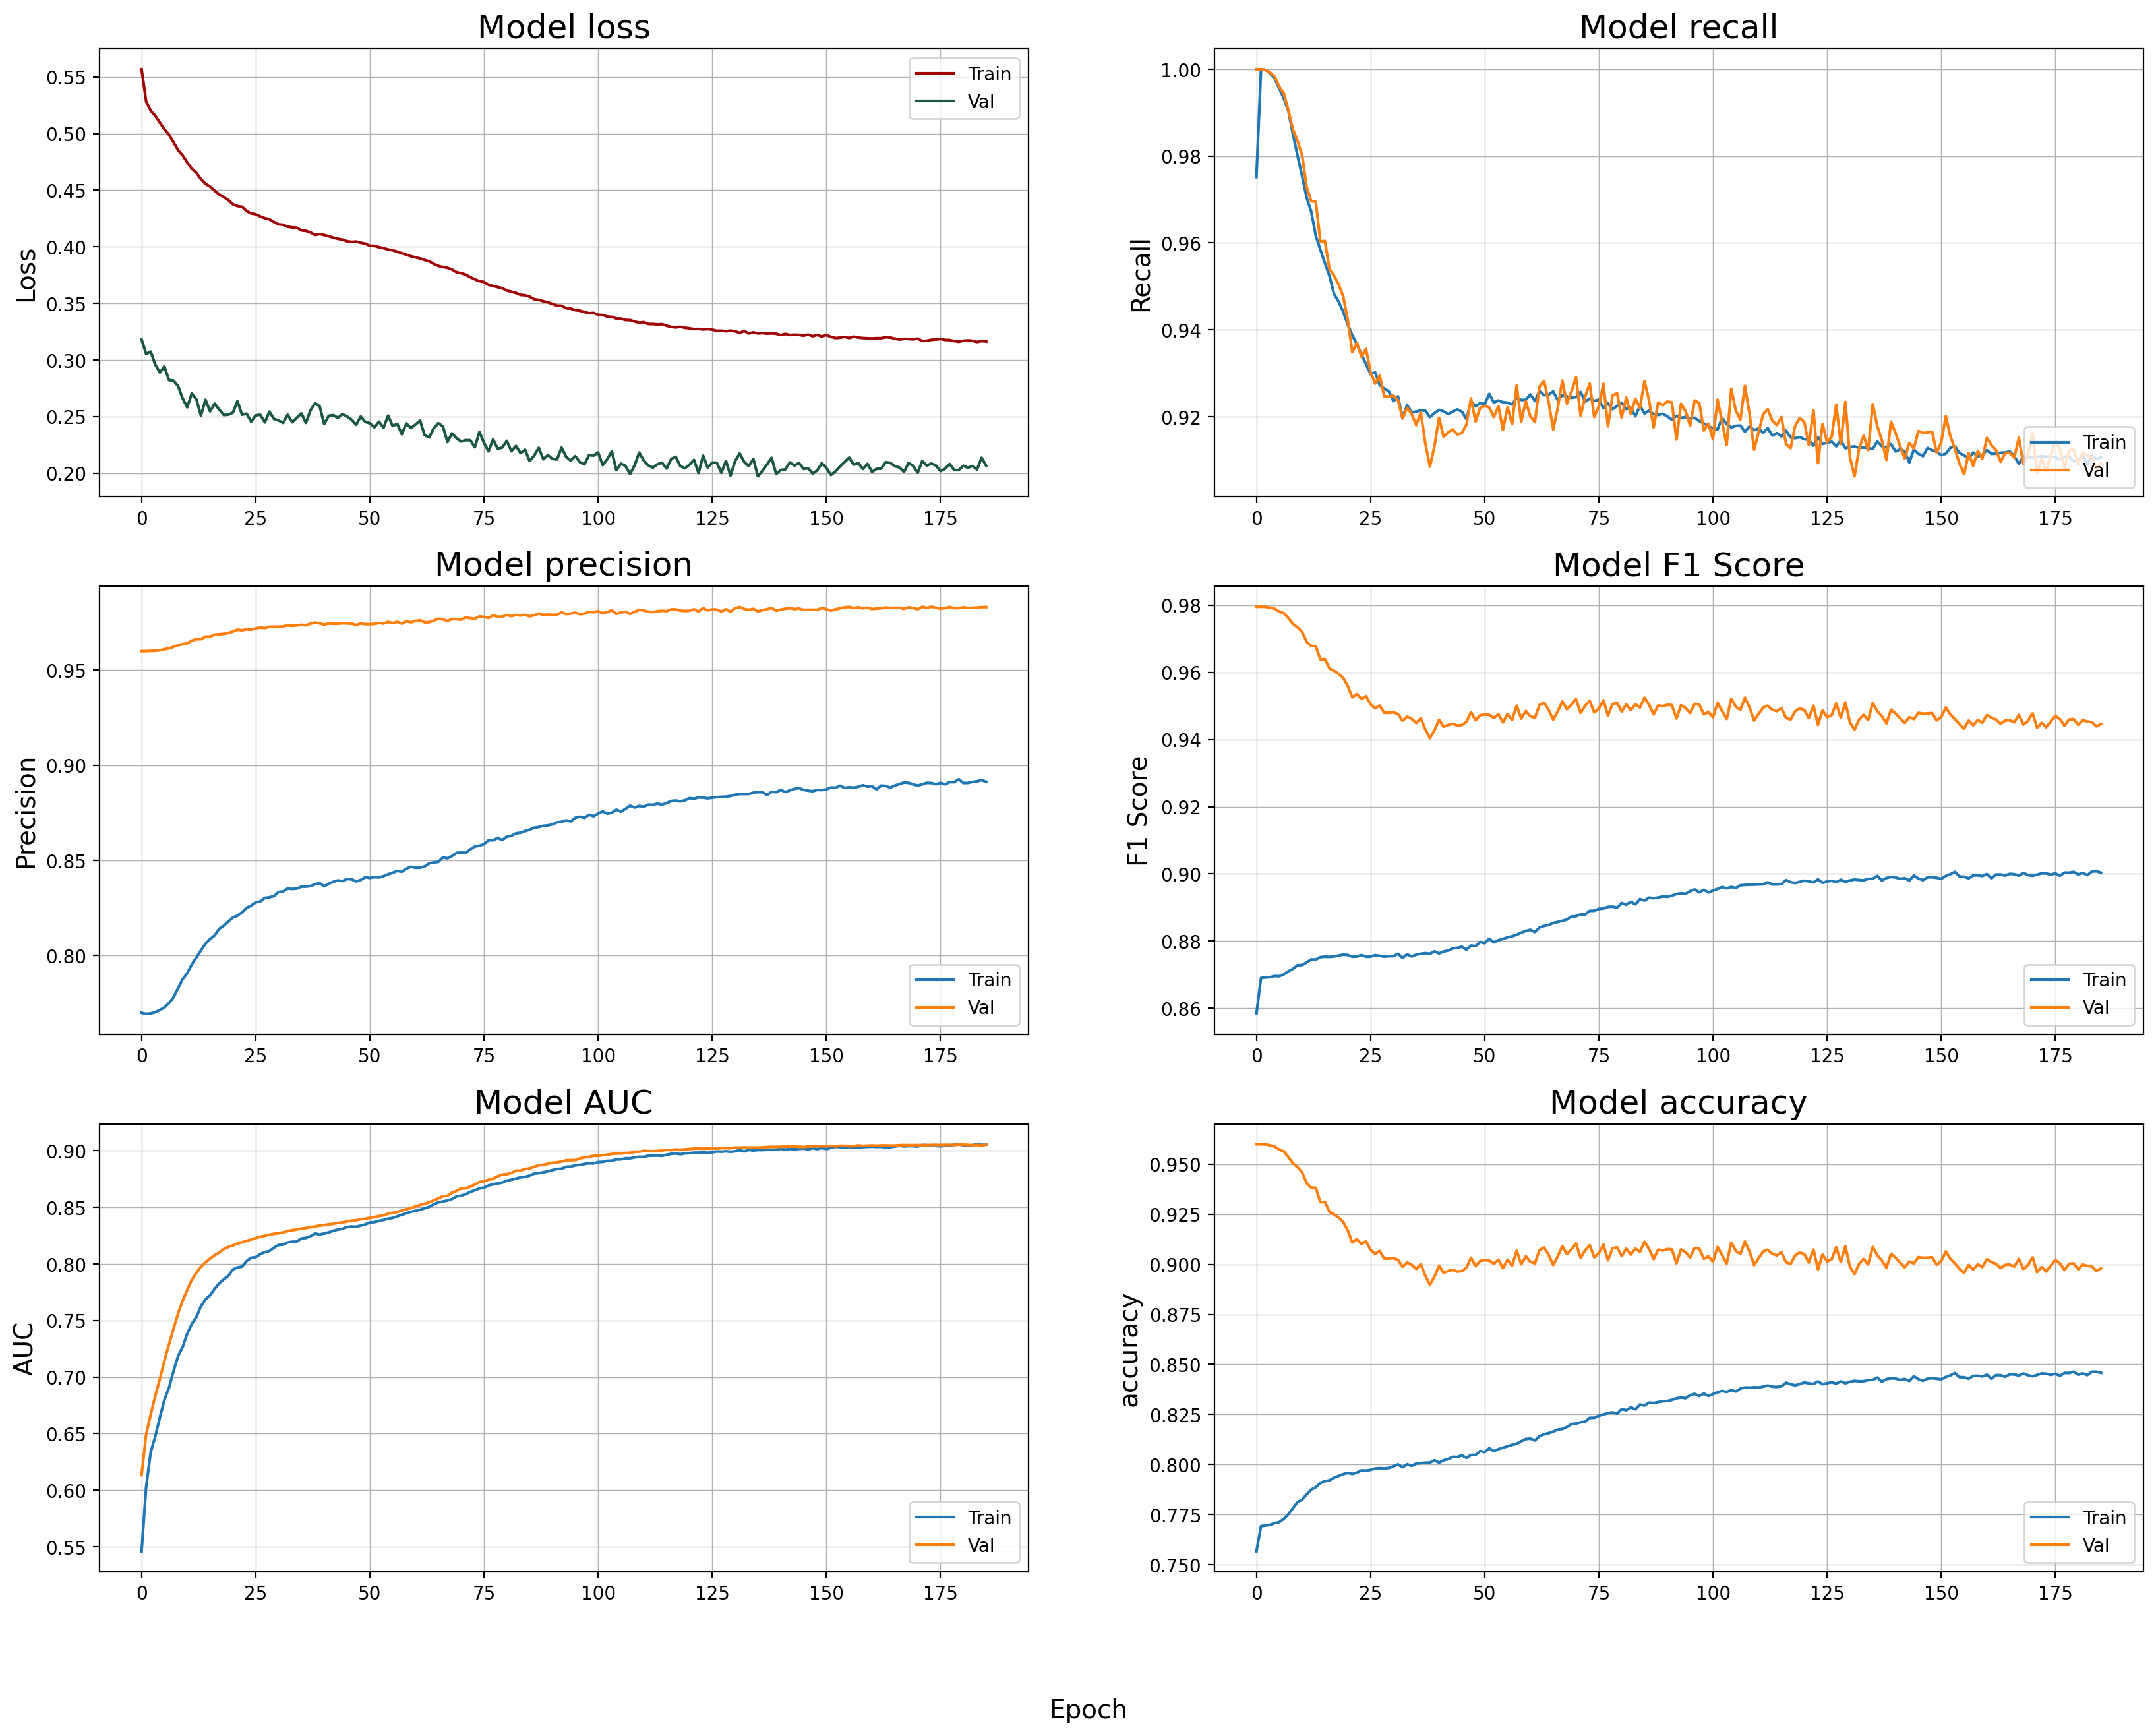

Show Up for Health


In [19]:
plot_loss_precision_recall_curve(history)
print("Show Up for Health")

# Score model on unseen dataset

In [20]:
model.predict(X_test)

4486/4486 [==============================] - 1s 274us/step


array([[0.9999185 ],
       [0.97479004],
       [0.59509504],
       ...,
       [0.9238715 ],
       [0.62524706],
       [0.99998534]], dtype=float32)

In [21]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

{'loss': 0.19627390801906586,
 'cross entropy': 0.19627390801906586,
 'f1_score': 0.9504432678222656,
 'accuracy': 0.9090991616249084,
 'precision': 0.9818786382675171,
 'recall': 0.9224575161933899,
 'auc': 0.9049500226974487,
 'prc': 0.9957518577575684}

In [23]:
from datetime import datetime

now = datetime.now()
datetime_string = now.strftime("%Y-%m-%d %H-%M-%S")

model.save(f'{MODEL_OUTPUT}/model_weights_{datetime_string}.h5') 

In [25]:
y_pred_proba = model.predict(X_test)

4486/4486 [==============================] - 1s 271us/step


## Confusion Matrix

In [66]:
threshold = 0.5 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

In [67]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

array([[  3216,   2349],
       [ 10699, 127277]])

Text(0.5, 25.722222222222214, 'Predicted label')

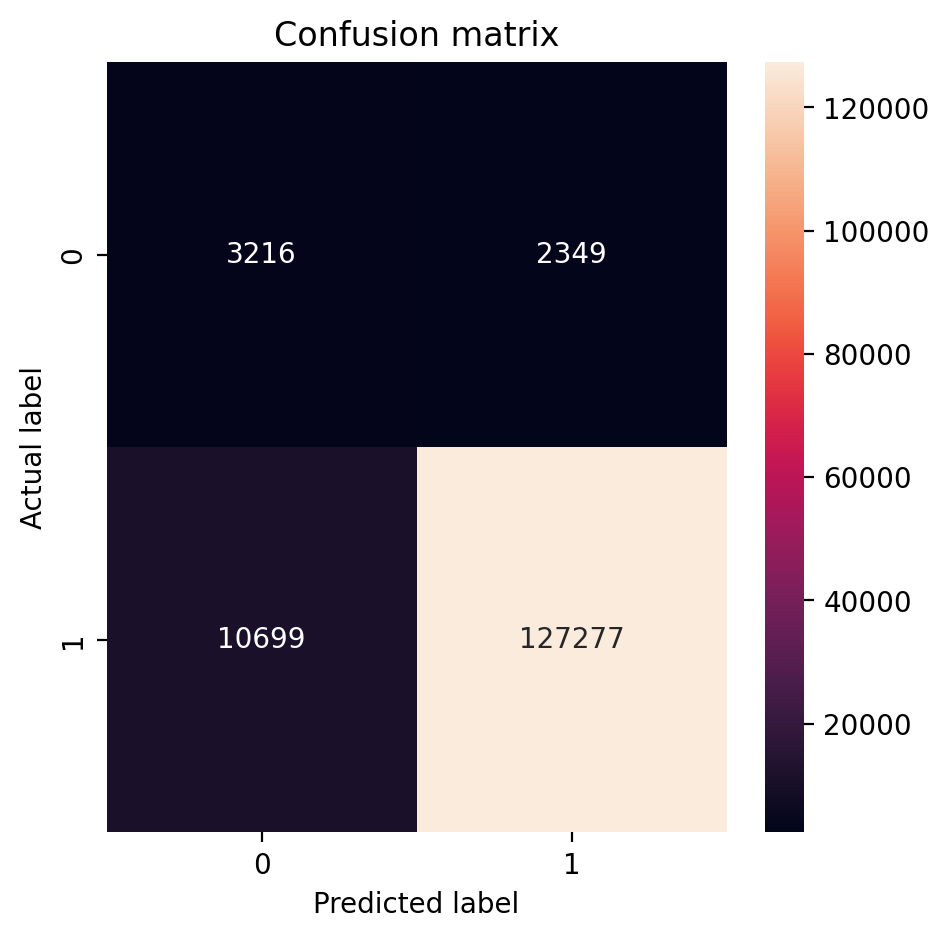

In [68]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.27      0.39      0.32      5565
         1.0       0.98      0.96      0.97    137976

    accuracy                           0.94    143541
   macro avg       0.62      0.68      0.64    143541
weighted avg       0.95      0.94      0.94    143541



In [96]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

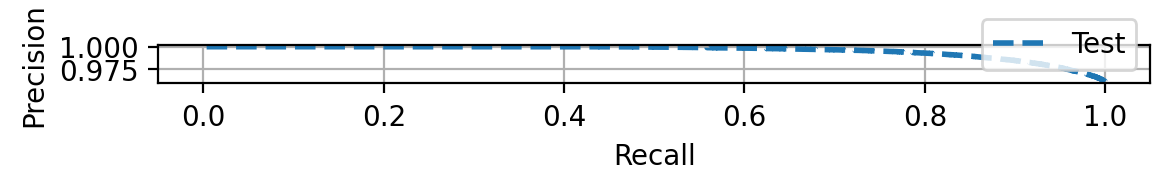

In [97]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')

In [98]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities from model
y_true = test_labels 
y_probas = model.predict(test_data)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probas)

# Calculate AUC score
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)'% auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'test_labels' is not defined